In [1]:
import sys

sys.path.append("..")  # Adds the parent directory to the sys.path

from utitlity_functions import *
import numpy as np
from matplotlib import pyplot as plt
from scipy import ndimage
import cv2 as cv
from matplotlib import cm
import matplotlib.patches as mpatches
from sklearn.cluster import KMeans
from PIL import Image, ImageDraw
from hough_circle_trafo import hough_circle
from confectionery import Confectionery
import seaborn_image as isns
from matplotlib.ticker import MaxNLocator
import matplotlib
plt.rcdefaults()
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'font.size' : 11,
    'text.usetex': True,
})
np.random.seed(137)

In [2]:
im=cv.imread("/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/Image_Data/Aufnahmen_JPEG_06_07_take_2/Hoang_07_06_2023_Aufnahmen_Rollen_Partikel_Rollen_12_mu_200_002_t193.jpg", cv.IMREAD_GRAYSCALE)
object_trajectory=np.load("/Users/Hoang_1/Desktop/Master_Arbeit/software/Janus_Particle_Tracking/data/obj_traj_1.npy")
object_state=object_trajectory[193,:]
a=50
x=round(object_state[1])
y=round(object_state[2])

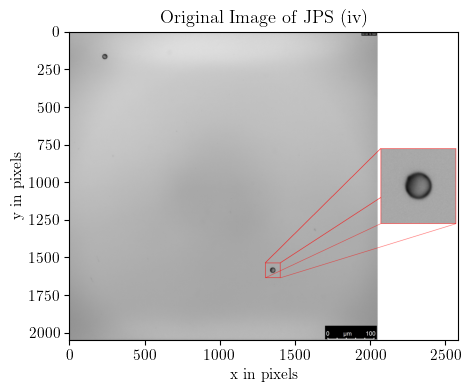

In [3]:
# Open the original image
original_image = Image.open("/Users/Hoang_1/Desktop/Master_Arbeit/software/janus_particle_tracking/Image_Data/Aufnahmen_JPEG_06_07_take_2/Hoang_07_06_2023_Aufnahmen_Rollen_Partikel_Rollen_12_mu_200_002_t193.jpg")

resize_length=500
# Define the coordinates of the ROI rectangle (left, top, right, bottom)
x1=x-a
x2=x+a
y1=y-a
y2=y+a
roi_coordinates = (x1, y1, x2, y2)  # Update these values

# Crop the ROI from the original image
roi = original_image.crop(roi_coordinates)

# Enlarge the ROI
enlarged_roi = roi.resize((resize_length, resize_length))  # Update new_width and new_height

# Create a blank canvas for the illustration
illustration_width = original_image.width+enlarged_roi.width + 40  # Adjust as needed
illustration_height = max(original_image.height, enlarged_roi.height)  # Adjust as needed
illustration = Image.new("RGB", (illustration_width, illustration_height), "white")

x1_new=original_image.width + 20
y1_new=(illustration_height-resize_length)//2
x2_new=original_image.width + 20 + resize_length
y2_new=(illustration_height+resize_length)//2

# Paste the original image on the canvas
illustration.paste(original_image, (0, 0))  # Adjust the coordinates as needed
draw = ImageDraw.Draw(illustration)
draw.line(
    [(x2, y1), (x2_new, y1_new)],
    fill="red",
    width=3,
)

# Paste the enlarged ROI on the canvas
illustration.paste(enlarged_roi, (original_image.width + 20, (illustration_height-resize_length)//2))  # Adjust the coordinates as needed

draw.rectangle(roi_coordinates, outline="red", width=3)
shape2=(x1_new, y1_new, x2_new, y2_new)
draw.rectangle(shape2, outline="red",width=3)
draw.line(
    [(x1, y1), (x1_new, y1_new)],
    fill="red",
    width=3,
)
draw.line(
    [(x1, y2), (x1_new, y2_new)],
    fill="red",
    width=3,
)
draw.line(
    [(x2, y2), (x2_new, y2_new)],
    fill="red",
    width=3,
)

fig=plt.figure()
fig.set_size_inches(10,4) 
plt.title("Original Image of JPS (iv)")
plt.xlabel("x in pixels")
plt.ylabel("y in pixels")
plt.imshow(illustration,cmap="gray",vmin=0,vmax=255)
plt.show()
fig.savefig('../export_graphs/filtering_JPS_original.eps', format="eps", dpi=1200, bbox_inches="tight")

In [4]:
im=im[y-a:y+a+1,x-a:x+a+1]

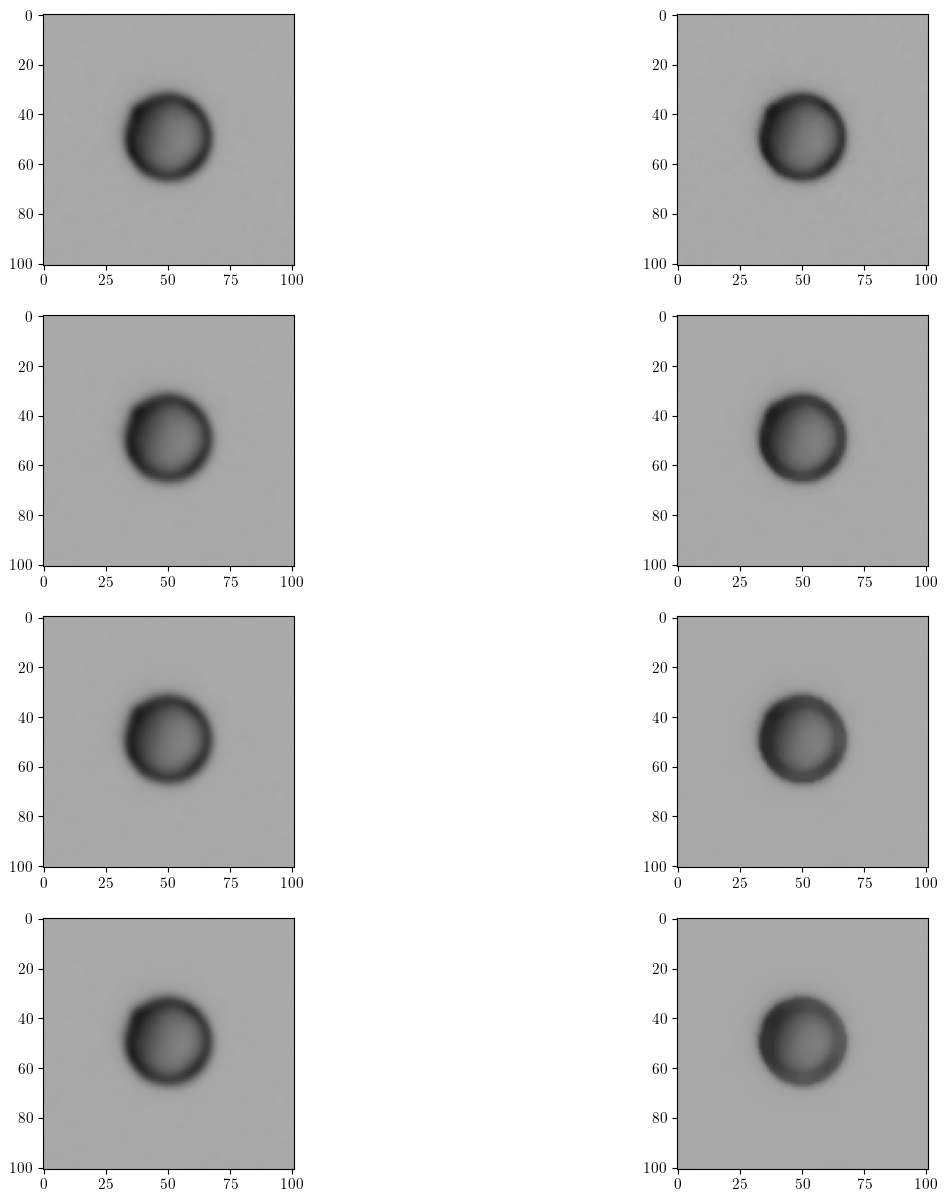

In [5]:
window_sizes=[3,5,7,9]
im_gaussian=[]
im_median=[]

for i in window_sizes:
    im_gaussian.append(cv.GaussianBlur(im.astype(np.float64), ksize=(i,i), sigmaX=1))
    im_median.append(cv.medianBlur(im, ksize=i))

fig,ax=plt.subplots(4,2)
fig.set_figheight(15)
fig.set_figwidth(15)

for i in range(4):
    ax[i,0].imshow(im_gaussian[i],cmap="grey",vmin=0,vmax=255)
    ax[i,1].imshow(im_median[i],cmap="grey",vmin=0,vmax=255)

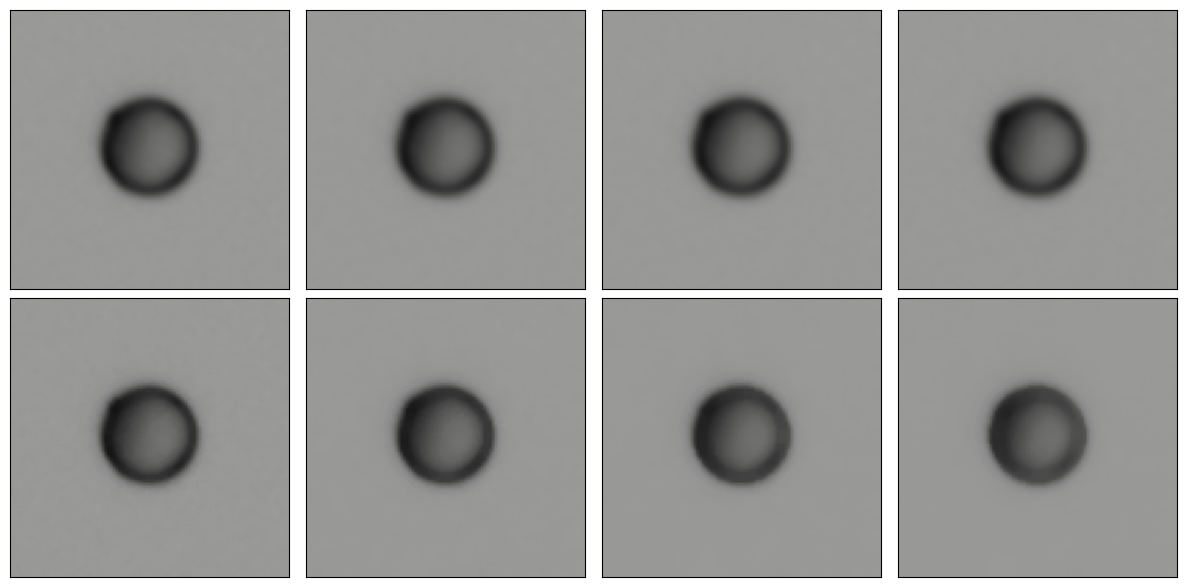

In [6]:
ims=[]
for i in range(4):
    ims.append(im_gaussian[i])
for i in range(4):
    ims.append(im_median[i])
g =isns.ImageGrid(ims, col_wrap=4, cbar=False,cmap="gray",vmin=0,vmax=255)


In [7]:
dirac=np.zeros((1,5))
dirac[0,2]=1
print(cv.GaussianBlur(dirac, ksize=(3,3), sigmaX=1))
print(cv.GaussianBlur(dirac, ksize=(5,5), sigmaX=1))
a=np.exp(-0.5*np.array([1,0,1]))
print(a/np.sum(a))
a=np.exp(-0.5*np.array([4,1,0,1,4]))
normalize_constant=np.sum(a)
a_pad=np.pad(a,pad_width=[2,2],mode='reflect')
print(a/np.sum(a))
print(a_pad/normalize_constant)


[[0.         0.27406862 0.45186276 0.27406862 0.        ]]
[[0.10897737 0.24420134 0.40261995 0.24420134 0.10897737]]
[0.27406862 0.45186276 0.27406862]
[0.05448868 0.24420134 0.40261995 0.24420134 0.05448868]
[0.40261995 0.24420134 0.05448868 0.24420134 0.40261995 0.24420134
 0.05448868 0.24420134 0.40261995]


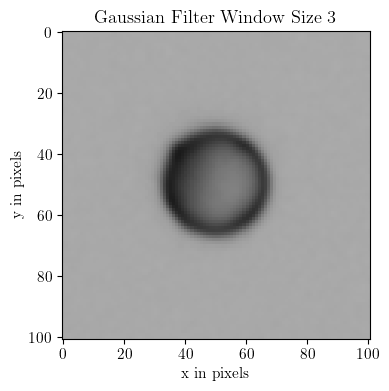

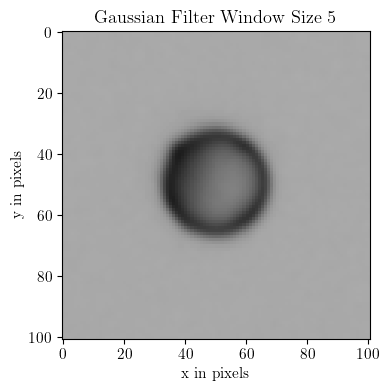

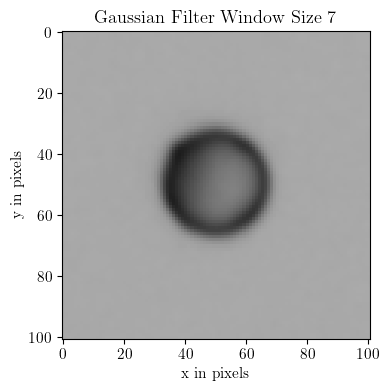

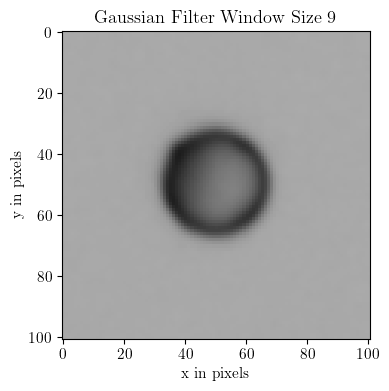

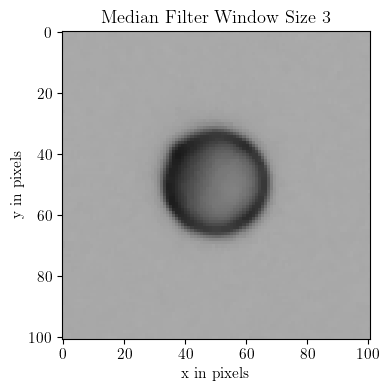

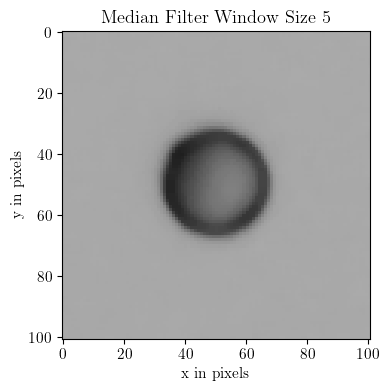

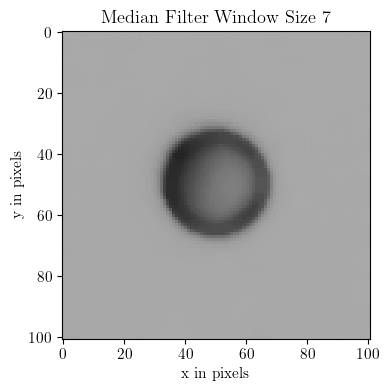

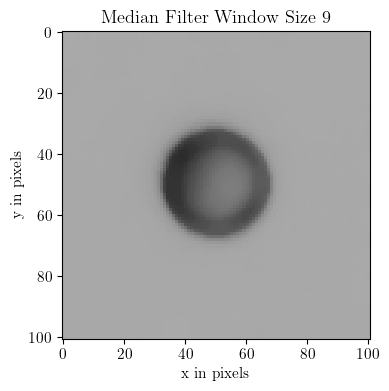

In [8]:
for i in range(4):
    fig=plt.figure()
    fig.set_size_inches(10,4) 
    plt.title("Gaussian Filter Window Size "+str(window_sizes[i]))
    plt.imshow(im_gaussian[i],cmap="gray",vmin=0,vmax=255)
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.show()
    fig.savefig('../export_graphs/filtering_JPS_gauss_'+str(i)+'_.eps', format="eps", dpi=1200, bbox_inches="tight")
for i in range(4):
    fig=plt.figure()
    fig.set_size_inches(10,4) 
    plt.title("Median Filter Window Size "+str(window_sizes[i]))
    plt.xlabel("x in pixels")
    plt.ylabel("y in pixels")
    plt.imshow(im_median[i],cmap="gray",vmin=0,vmax=255)
    plt.show()
    fig.savefig('../export_graphs/filtering_JPS_median_'+str(i)+'_.eps', format="eps", dpi=1200, bbox_inches="tight")

# afterwards border thickness detection plots

In [9]:
def calculate_normed_means_on_radius(im_obj_gray):
    """
    Input
    -----
    im_gray: square shaped image array centered around center of JPS. (NxN, N is odd)
    direction: masking direction: String

    Output
    ------
    means on radius/ std: (normed means, array of size radius of obj)
    """
    koppenrath=Confectionery()
    radius_obj=im_obj_gray.shape[0]//2
    M=koppenrath.sell_cake(radius_obj,im_obj_gray.shape[0],im_obj_gray.shape[0])
    total_std=im_obj_gray[M==1].std()
    masks=[koppenrath.sell_donut(radius_obj-i,im_obj_gray.shape[0],im_obj_gray.shape[0]) for i in range(radius_obj+1)]
    values_on_radius=[im_obj_gray[m==1].reshape(-1) for m in masks]
    means_on_radius=[x.mean() for x in values_on_radius]
    std_on_radius=[x.std() for x in values_on_radius]
    return np.array(means_on_radius), np.array(std_on_radius), total_std

In [10]:
r=round(np.mean(object_trajectory[:,-1]))
im_gaussian_obj=[]
means_gauss=[]
std_gauss=[]
im_median_obj=[]
means_median=[]
std_median=[]
for i in range(4):
    x=(im_gaussian[i].shape)[0]//2
    obj_im=im_gaussian[i][x-r:x+r+1,x-r:x+r+1]
    im_gaussian_obj.append(obj_im)
    means_gauss.append(calculate_normed_means_on_radius(obj_im)[0])
    std_gauss.append(calculate_normed_means_on_radius(obj_im)[1])

for i in range(4):
    x=(im_median[i].shape)[0]//2
    obj_im=im_median[i][x-r:x+r+1,x-r:x+r+1]
    im_median_obj.append(obj_im)
    means_median.append(calculate_normed_means_on_radius(obj_im)[0])
    std_median.append(calculate_normed_means_on_radius(obj_im)[1])

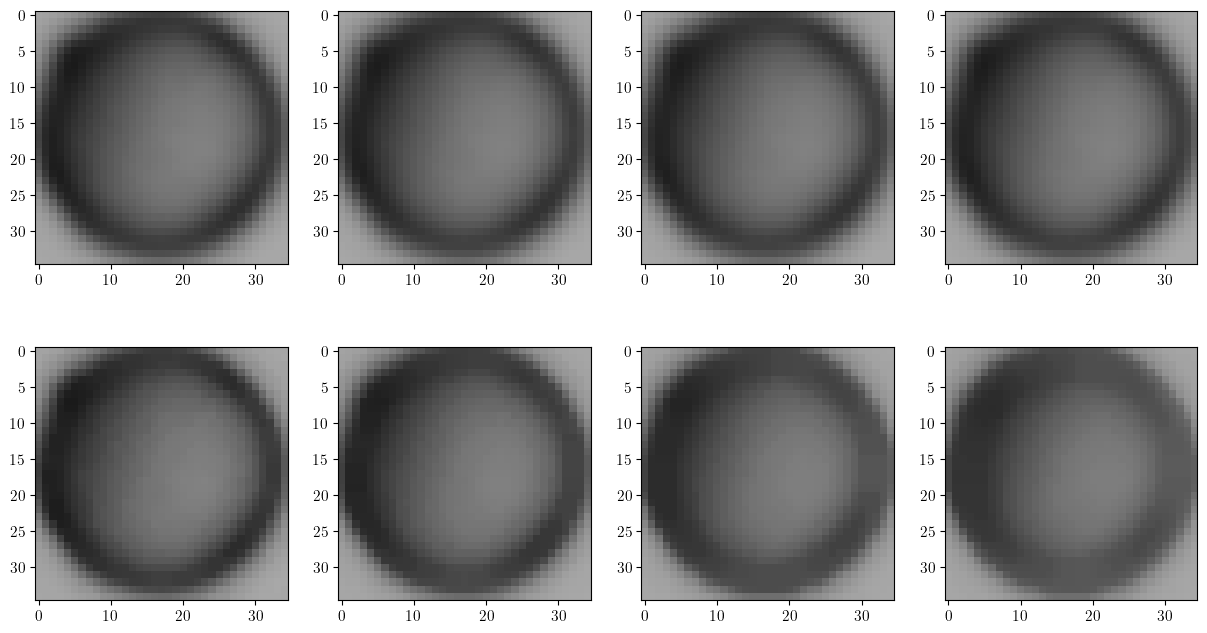

In [11]:
fig,ax=plt.subplots(2,4)
fig.set_figheight(8)
fig.set_figwidth(15)

for i in range(4):
    ax[0,i].imshow(im_gaussian_obj[i],cmap="grey",vmin=0,vmax=255)
    ax[1,i].imshow(im_median_obj[i],cmap="grey",vmin=0,vmax=255)

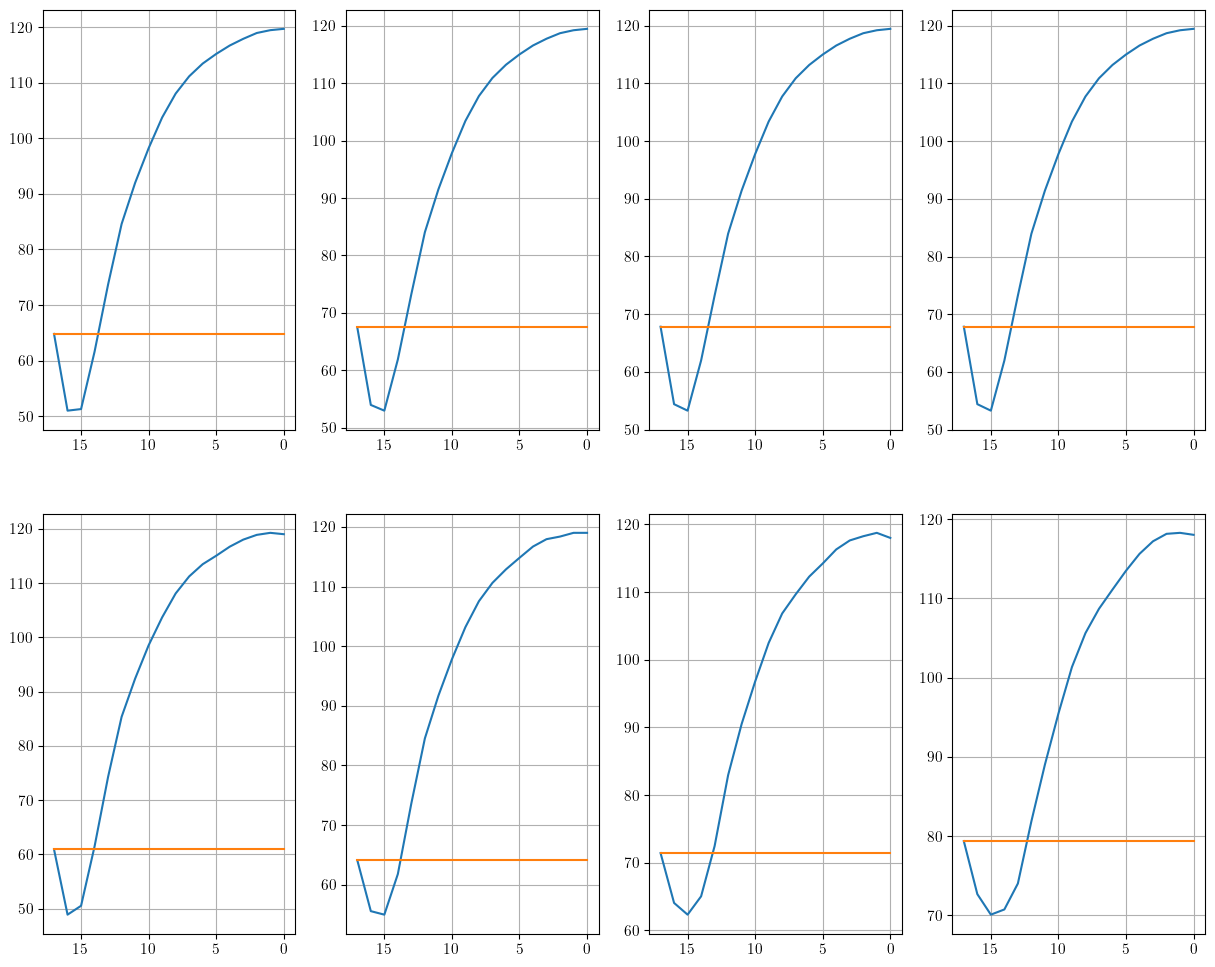

In [12]:
fig,ax=plt.subplots(2,4)
fig.set_figheight(12)
fig.set_figwidth(15)
t=np.arange(r+1)[::-1]
for i in range(4):
    ax[0,i].plot(t,means_gauss[i])
    ax[0,i].plot(t,means_gauss[i][0]*np.ones_like(t))
    ax[0,i].grid()
    ax[0,i].invert_xaxis()


    ax[1,i].plot(t,means_median[i])
    ax[1,i].plot(t,means_median[i][0]*np.ones_like(t))
    ax[1,i].grid()
    ax[1,i].invert_xaxis()



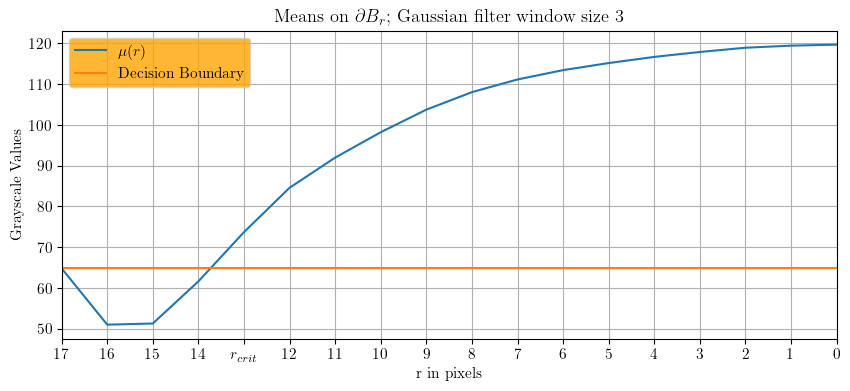

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


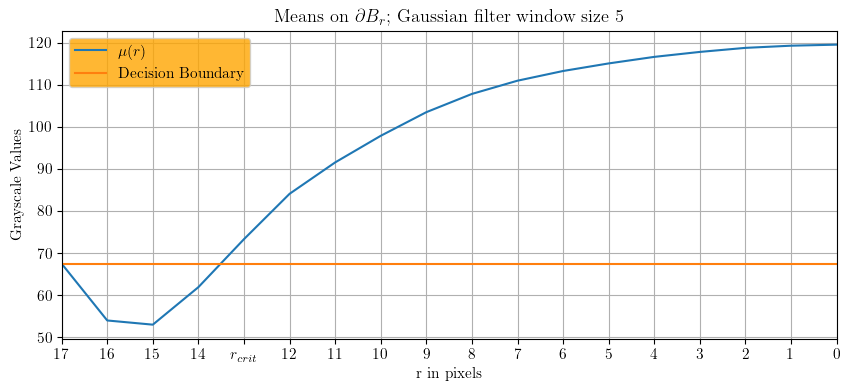

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


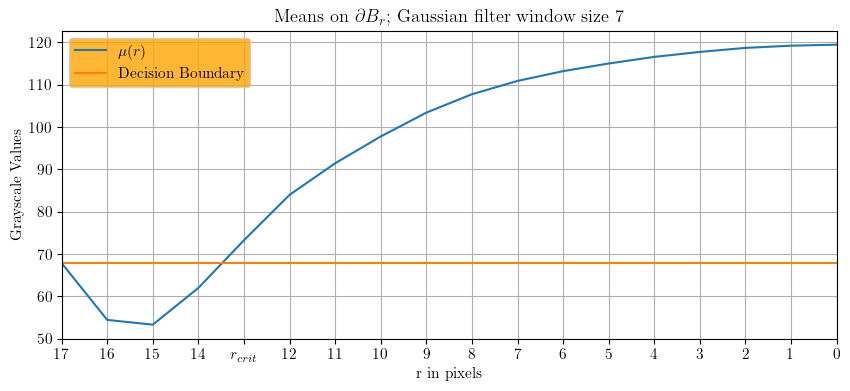

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


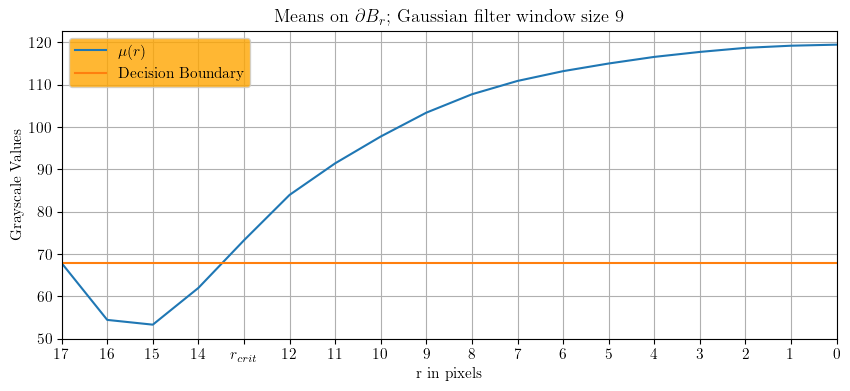

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [15]:
for i in range(4):
    fig=plt.figure()
    fig.set_size_inches(10,4) 
    plt.title("Means on $\partial B_{r}$; Gaussian filter window size "+str(window_sizes[i]))
    plt.plot(t,means_gauss[i],label="$\mu(r)$")
    plt.plot(t,means_gauss[i][0]*np.ones_like(t),label="Decision Boundary")
    plt.grid()
    ax = fig.gca()
    tick_labels = [str(i) for i in range(18)]
    tick_labels[13]='$r_{crit}$'
    ax.set_xticks(range(18),tick_labels)
    ax.set_xlim([0,17])
    ax.invert_xaxis()
    plt.xlabel("r in pixels")
    plt.ylabel("Grayscale Values")
    plt.legend(frameon=True, facecolor="orange")
    plt.show()
    fig.savefig('../export_graphs/JPS_border_gauss'+str(i)+'_.eps', format="eps", dpi=1200, bbox_inches="tight")

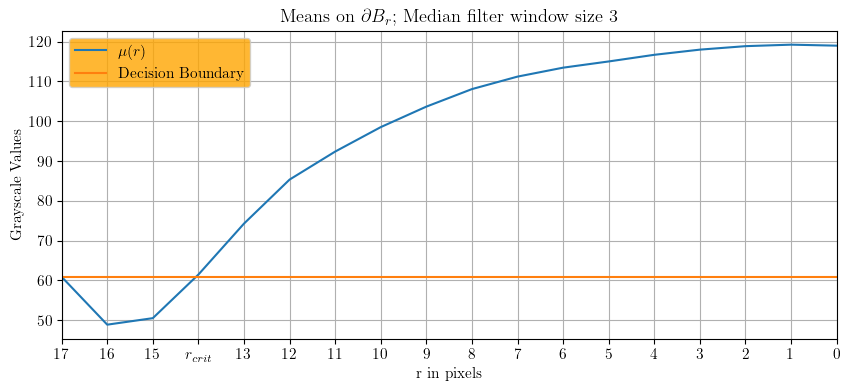

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


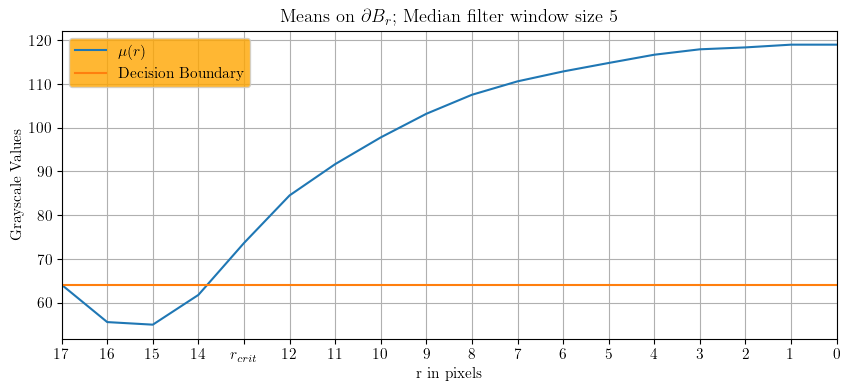

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


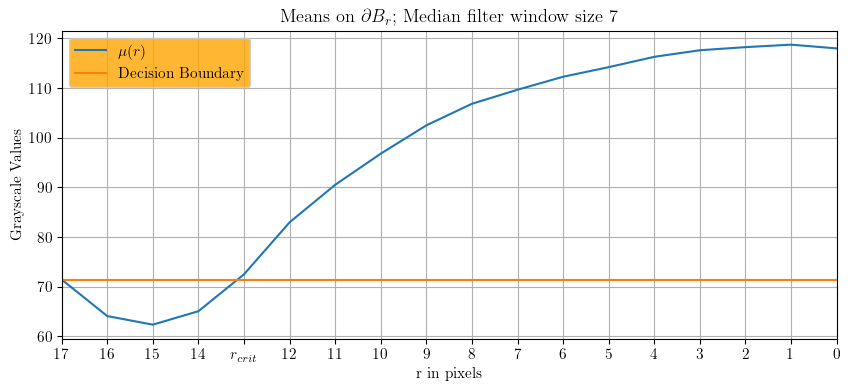

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


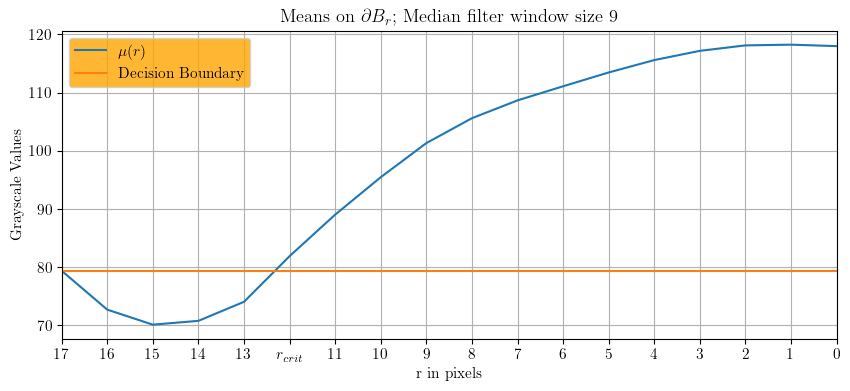

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


In [16]:
crit_index=[14,13,13,12]
for i in range(4):
    fig=plt.figure()
    fig.set_size_inches(10,4) 
    plt.title("Means on $\partial B_{r}$; Median filter window size "+str(window_sizes[i]))
    plt.plot(t,means_median[i],label="$\mu(r)$")
    plt.plot(t,means_median[i][0]*np.ones_like(t),label="Decision Boundary")
    plt.grid()
    ax = fig.gca()
    tick_labels = [str(i) for i in range(18)]
    tick_labels[crit_index[i]]='$r_{crit}$'
    ax.set_xticks(range(18),tick_labels)
    ax.set_xlim([0,17])
    ax.invert_xaxis()
    plt.xlabel("r in pixels")
    plt.ylabel("Grayscale Values")
    plt.legend(frameon=True, facecolor="orange")
    plt.show()
    fig.savefig('../export_graphs/JPS_border_median'+str(i)+'_.eps', format="eps", dpi=1200, bbox_inches="tight")